# TP -  Introduction to recurrent neural networks


## Chatbot with a sequence to sequence network and attention
*************************************************************

From Siri to Google Translate, deep neural networks have enabled breakthroughs in machine understanding of natural language. Most of these models treat language as a flat sequence of words or characters, and use a kind of model called a recurrent neural network (RNN) to process this sequence

**In this project we will be teaching a neural network to anwers various questions about the admission to the master in Data Science of Lyon 1** to varying degrees of success... 

The code is adapated from the Pytorch example "Translation with a Sequence to Sequence Network and Attention".
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

Sentences are in French. Example: [> input, = target, < output]

    
    > pourriez vous me renseigner ?
    = oui volontiers d ou venez vous ?
    < oui volontiers <EOS>

    > quel est le corps professoral ?
    = il est compose de chercheurs du liris 
    < il est compose de chercheurs du liris  <EOS>
    
To deal with these types of variable-length input and output, we need to use a recurrent neural network (RNN). Feed-forward neural networks, such as convolutional neural networks, do not maintain internal state other than the network’s own parameters. An RNN maintains its internal state while reading a sequence of inputs, which in our case will be a sequence of words, thereby being able to process an input of any length.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an **attention mechanism**, which lets the decoder
learn to focus over a specific range of the input sequence. The approach of incorporating attention mechanism has become one of the hottest topics in deep learning recently (<https://arxiv.org/abs/1507.01053>, <https://arxiv.org/abs/1409.0473>`).


**Recommended Reading:**

-  http://pytorch.org/ For installation instructions
-  doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  doc:`/beginner/pytorch_with_examples` for a wide and deep overview


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  'Recursive Neural Networks with PyTorch with a recurrent tracker and TreeLSTM nodes
    <https://devblogs.nvidia.com/parallelforall/recursive-neural-networks-pytorch>`
-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`


In [43]:
%matplotlib inline

In [44]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import seq2seq.loss

use_cuda = torch.cuda.is_available()
use_cuda = False

Loading data files
==================

The data for this project is a set of questions/anwers pairs.


We will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
hundred words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [45]:
SOS_token = 0
EOS_token = 1
UNSEEN_TOKEN = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"UNSEEN" : UNSEEN_TOKEN}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2:"UNSEEN"}
        self.n_words = 3  # Count SOS and EOS and unseen

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [46]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters except digits
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
#    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

In [47]:
s="Est-il possible de s'inscrire au M2 en 2018 ?"
normalizeString(s)

'est il possible de s inscrire au m2 en 2018 ?'

To read the data file we will split the file into lines, and then split
lines into pairs. If we want to infer the question from the answers, I added the ``reverse``
flag to reverse the pairs.




In [48]:
def readLangs(questions, answers, reverse=False):
    print("Reading lines...")
        
    lines = open('data/chatbot-M2-DS.txt', encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(answers)
        output_lang = Lang(questions)
    else:
        input_lang = Lang(questions)
        output_lang = Lang(answers)

    return input_lang, output_lang, pairs

Here the maximum length is 10 words (that includes
ending punctuation) 

In [49]:
MAX_LENGTH = 10

stopwords = ['de','d','le','la','l','du','d','ce','c','m','me','ma','si','t','sur'\
             'n','en','il', 'les','des','est','sont','s', 'a','y','au','un','une',\
             'on', 'nous', 'je', 'j','vous']

def TrimWords(pairs):
    for pair in pairs: #[pair for pair in pairs]:
        resultwords  = [word for word in pair[0].split() if word.lower() not in stopwords]
        pair[0] = ' '.join(resultwords)
    return pairs

 
def TrimWordsTest(question):
    resultwords  = [word for word in question.split() if word.lower() not in stopwords]
    question = ' '.join(resultwords)
    return question


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [50]:
input_lang, output_lang, pairs = readLangs('questions', 'answers', False)
pairs = TrimWords(pairs)
for pair in [pair for pair in pairs if not filterPair(pair)]:
    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split(' ')),pair[1],len(pair[1].split(' ')))) #   

Reading lines...
viens strasbourg . (3) -> il y a cinq places disponibles dans ce master . (10)


The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [51]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = TrimWords(pairs)
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 193 sentence pairs
Trimmed to 192 sentence pairs
Counting words...
Counted words:
questions 214
answers 200
['master oriente recherche ou entreprise ?', 'il s agit d un m2 indifferencie']


In [52]:
pairs[:10]

[['quels parcours ?',
  'le m2 ouvre en informatique et mathematiques appliquees'],
 ['m2 ou m1 ?', 'c est un m2'],
 ['quels mentions ?', 'mention informatique ou mathematiques'],
 ['souhaite inscrire', 'les inscriptions 2018 se font sur ecandidat'],
 ['veux inscrire', 'les inscriptions 2018 se font sur ecandidat'],
 ['souhaite postuler', 'les inscriptions 2018 se font sur ecandidat'],
 ['souhaite postuler master 2018', 'les inscriptions se font sur ecandidat'],
 ['quels apprentissages ?',
  'acquerir un socle de connaissances techniques en machine learning'],
 ['quels cours ?',
  'acquerir un socle de connaissances techniques en machine learning'],
 ['atouts parcours ?', 'une pedagogie fondee sur de nombreuses etudes de cas']]

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for dialogue systems.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


In [53]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to produce the answer.




**Simple Decoder**

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).



In [54]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




# Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.



In [55]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

Note: There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`

# Training


Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [56]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct answer -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the answer
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [100]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [58]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [59]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, criterion=nn.NLLLoss()):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [60]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [83]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [62]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it's easier to run multiple experiments easier) we can actually
initialize a network and start training.

Remember that they are very few input sentences. For this small
dataset we can use relatively small networks of 100 hidden nodes and a
single GRU layer. After about 3 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 5s (- 0m 52s) (500 10%) 3.1339
0m 11s (- 0m 47s) (1000 20%) 2.8242
0m 18s (- 0m 42s) (1500 30%) 2.5815
0m 24s (- 0m 37s) (2000 40%) 2.4395
0m 30s (- 0m 30s) (2500 50%) 1.9841
0m 36s (- 0m 24s) (3000 60%) 1.6535
0m 43s (- 0m 18s) (3500 70%) 1.4052
0m 50s (- 0m 12s) (4000 80%) 1.0905
0m 58s (- 0m 6s) (4500 90%) 0.8987
1m 5s (- 0m 0s) (5000 100%) 0.6361


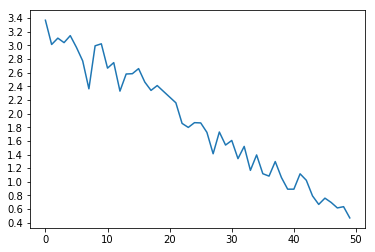

In [63]:
#hidden_size = 256
hidden_size = 100
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 5000, print_every=500)

In [64]:
evaluateRandomly(encoder1, attn_decoder1)

> ai question
= oui posez votre question
< oui volontiers quel est votre profil ? <EOS>

> combien places ?
= il y a 20 places en tout
< il y a 20 places en tout <EOS>

> quels connaissances demandees ?
= mathematiques et statistiques
< mathematiques et statistiques <EOS>

> quel reputation master ?
= c est a vous de faire sa reputation .
< des chercheurs du liris de <EOS>

> viens reims ?
= cinq places pour les titulaires d un master francais
< cinq places pour les titulaires d un master francais <EOS>

> souhaite postuler master 2018
= les inscriptions se font sur ecandidat
< les inscriptions se font sur ecandidat <EOS>

> quand ?
= le cinq septembre
< le 5 septembre 2018 <EOS>

> pouvez aider ?
= oui je suis la pour vous renseigner
< oui je suis la pour vous renseigner <EOS>

> ai questions
= oui posez vos questions
< je suis la pour vous renseigner <EOS>

> eu redoublants annees passees ?
= non un seul
< non un seul <EOS>



/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Asking new questions
=========

Ask new questions (never seen during training) using only the words that appear in your training set. 
No capital letters, nor numbers.

In [65]:
newpair='bonjour monsieur'
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair='quels sont les cours dispenses dans ce master ?'
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair='et les prerequis ?'
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair="la rentree en 2018 c est quand ?"
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair="c est un master en un an ?"
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair="quels sont les enseignants du master ?"
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)
newpair='merci monsieur'
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)

bonjour monsieur
-> bonjour <EOS>
quels cours dispenses dans master ?
-> des chercheurs du liris <EOS>
et prerequis ?
-> le niveau est plutot bon <EOS>
rentree 2018 quand ?
-> le 5 septembre 2018 <EOS>
master an ?
-> oui c est un m2 d un an . <EOS>
quels enseignants master ?
-> des chercheurs du liris <EOS>
merci monsieur
-> de rien <EOS>


/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(None, None)

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


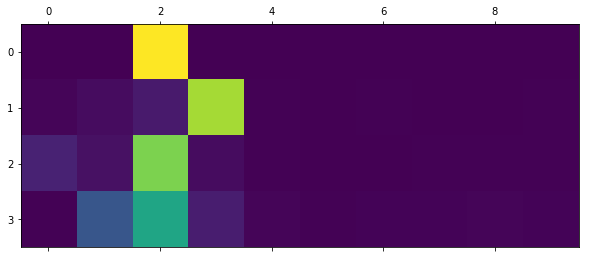

In [66]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, TrimWordsTest("quels sont les debouches ?"))
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = quelle date rentree 2018 ?
output = le 5 septembre 2018 <EOS>


/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


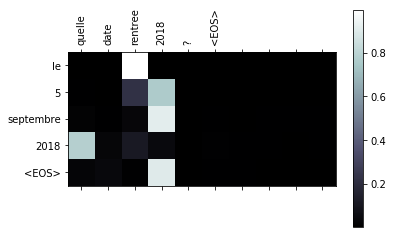

input = m2 prepare quel metier ?
output = au metier de data scientist <EOS>


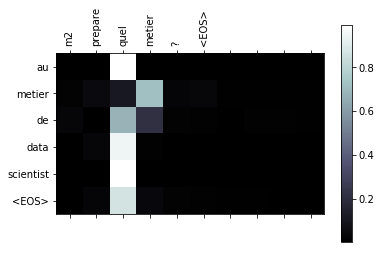

In [67]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(TrimWordsTest("a quelle date est la rentree 2018 ?"))
evaluateAndShowAttention(TrimWordsTest("ce m2 prepare a quel metier ?"))

Future work
=========

-  Discuss the weaknesses of this simple approach
-  Allow words in the new questions that are unseen during training.
-  Allow questions of > 10 words (for instance, by selecting 10 words at random in the sentence).
-  Adapt the code to handle several sequences at once (like an email)
-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe.
-  Try with more layers, more/less hidden units, and more sentences. Compare
   the training time and performance.
-  Define and plot other loss functions for this specific task (e.g. % correct words)
-  If pairs have two of the same phrase (``Bonjour \t Bonjour``), you can 
   use this as an autoencoder. Try this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for answering the questions from there




# Faiblesses du modèle
- Le vocabulaire restreint qui ne permet pas de répondre aux questions qui contiennent des mots nouveaux et aussi comme on a "supprimer" les "stopwords", les réponses ne peuvent pas être gramaticalement correcte
- On pourrait rajouter des inputs au Décodeur comme par exemple le dernier mot prédit afin de permettre au modèle de savoir quel mot il a choisi et donc de ne pas répéter les mêmes mots, et l'état caché de l'Encodeur à chaque nouveaux mots dans la question en plus de l'état caché calculé afin de garder la "signification" de la question

# Autoriser des mots non vu pendant la phase d'apprentissage

On rajoute un token UNSEEN dans la classe LANG et à chaque fois qu'un nouveau mot est utilisé dans une question il est
remplacé par ce TOKEN (changement dans la fonction indexesFromSentence)

In [68]:
def indexesFromSentence(lang, sentence):
    res = list()
    for word in sentence.split(' '):
        try:
            res.append(lang.word2index[word])
        except KeyError:
            res.append(lang.word2index['UNSEEN'])
    return res

In [69]:
# utility function for tests
def one_test(newpairs):
    newpair = TrimWordsTest(newpairs)
    output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
    output_sentence = ' '.join(output_words)
    return newpair + ' -> ' + output_sentence
    
def test(*strigs_to_test):
    for newpair in strigs_to_test:
        print(one_test(newpair))

test('bonjour monsieur', 'bonjour monsieur Aussem', 'coucou monsieur')

bonjour monsieur -> bonjour <EOS>
bonjour monsieur Aussem -> bonjour <EOS>
coucou monsieur -> bonjour <EOS>


/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


On voit que cette "technique" a un gros défaut, si on rencontre un mot inconnue la réponse donnée peut sembler aléatoire.

# Autoriser les questions de longueur supérieure à 10 mots

In [70]:
def choose_words(indexes):
    if len(indexes) <= 9:
        return indexes
    while len(indexes) > 9:
        # dete unknown word in priority
        unknown = [i for i,x in enumerate(indexes) if x == UNSEEN_TOKEN]
        if unknown:
            delete = np.random.choice(unknown)
            indexes.pop(delete)
        else:
            delete = np.random.choice(range(len(indexes)))
            indexes.pop(delete)
    return indexes
    
def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes = choose_words(indexes)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result
test("bonjour je voudrais savoir si on peut s'inscrire à ce master même si on ne comprend rien en mathématiques")

bonjour voudrais savoir peut s'inscrire à master même ne comprend rien mathématiques -> il faut refaire un master . <EOS>


/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Model plus complexe

/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 18s (- 2m 44s) (500 10%) 2.9361
0m 41s (- 2m 46s) (1000 20%) 3.0131
1m 5s (- 2m 33s) (1500 30%) 2.8827
1m 28s (- 2m 13s) (2000 40%) 2.3957
1m 51s (- 1m 51s) (2500 50%) 1.9199
2m 17s (- 1m 31s) (3000 60%) 1.5391
2m 40s (- 1m 8s) (3500 70%) 1.1940
3m 1s (- 0m 45s) (4000 80%) 0.9554
3m 23s (- 0m 22s) (4500 90%) 0.7076
3m 45s (- 0m 0s) (5000 100%) 0.4980


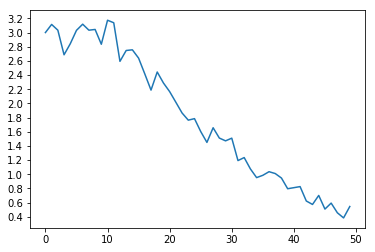

In [102]:
#hidden_size = 256
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               3, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 5000, print_every=500, criterion=nn.CrossEntropyLoss())

Le temps d'apprentissage semble être linéaire en fonction du nombre de couche 